<a href="https://colab.research.google.com/github/karthikeyansura/store-sales-time-series-modeling/blob/data-preprocessing-BhanuHarshaY/store_sales_time_series_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Store Sales - Time Series Forecasting**

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestRegressor

# For Autoencoder (embedding-based feature selection)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


#### **To run this notebook, you need your personal Kaggle API credentials. Follow these steps to generate them:**

1.   Log into **[Kaggle.com](https://www.kaggle.com)**.
2.   Click your profile picture in the top-right corner and select **Settings**.
3. **Username:** Your username is listed at the top of the Account tab.
4. Scroll down to the **"Legacy API Credentials"** section and click on **"Create Legacy API Key"**
5. A file named `kaggle.json` will download to your computer. Open that and copy the random string found inside the `"key": "..."` section and Replace `"ENTER_YOUR_KEY_HERE"` and replace `"ENTER_YOUR_USERNAME_HERE"` with your actual username.



In [3]:
import os

# LOADING THE DATASET

# Kaggle API configuration
os.environ['KAGGLE_USERNAME'] = "ybhanuharsha"
os.environ['KAGGLE_KEY'] = "209993ae69ff75c58ef84faa88afaa1a"

# setup paths
COMP_NAME = 'store-sales-time-series-forecasting'
BASE_PATH = f'/content/{COMP_NAME}/'

# download files
if not os.path.exists(BASE_PATH):
    print(f"Downloading {COMP_NAME}...")
    !mkdir -p {BASE_PATH}

    !mkdir -p ~/.kaggle
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
        f.write('{"username":"' + os.environ['KAGGLE_USERNAME'] + '","key":"' + os.environ['KAGGLE_KEY'] + '"}')
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle competitions download -c {COMP_NAME} -p {BASE_PATH}
    !unzip -q {BASE_PATH}{COMP_NAME}.zip -d {BASE_PATH}
    !rm {BASE_PATH}{COMP_NAME}.zip
    print("Download complete.")
else:
    print("Data already downloaded.")

# load dataset into df
train = pd.read_csv(BASE_PATH + 'train.csv', parse_dates=['date'])
test = pd.read_csv(BASE_PATH + 'test.csv', parse_dates=['date'])
stores = pd.read_csv(BASE_PATH + 'stores.csv')
oil = pd.read_csv(BASE_PATH + 'oil.csv', parse_dates=['date'])
holidays = pd.read_csv(BASE_PATH + 'holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv(BASE_PATH + 'transactions.csv', parse_dates=['date'])

print(f"Train shape: {train.shape}")
print("All datasets loaded successfully!")

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 1.69GB/s]
Download complete.
Train shape: (3000888, 6)
All datasets loaded successfully!


**Rationale:** We selected this method to load the dataset because it allows the entire team to execute the code easily without requiring manual directory management on local machines. Rather than relying on individual file downloads or identical Google Drive configurations, this script automatically retrieves the data directly from Kaggle into the notebook environment at runtime.

Dataset Overview
Total number of samples in train dataset: 3000888
Total number of samples in test dataset: 28512
Total number of samples: 3029400
Total number of features: 6 features + 1 target variable (sales)

Supplementary Datasets Overview
Stores dataset shape: (54, 5)
Oil dataset shape: (1218, 2)
Holidays dataset shape: (350, 6)
Transactions dataset shape: (83488, 3)
Stores metadata: 54 stores with 5 features
Oil prices: 1218 daily records
Holidays: 350 holidays
Transactions: 83488 records

Train Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   log_sales    float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memor

,id,date,store_nbr,family,sales,onpromotion,log_sales
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0



Data Distribution of target class Sales:


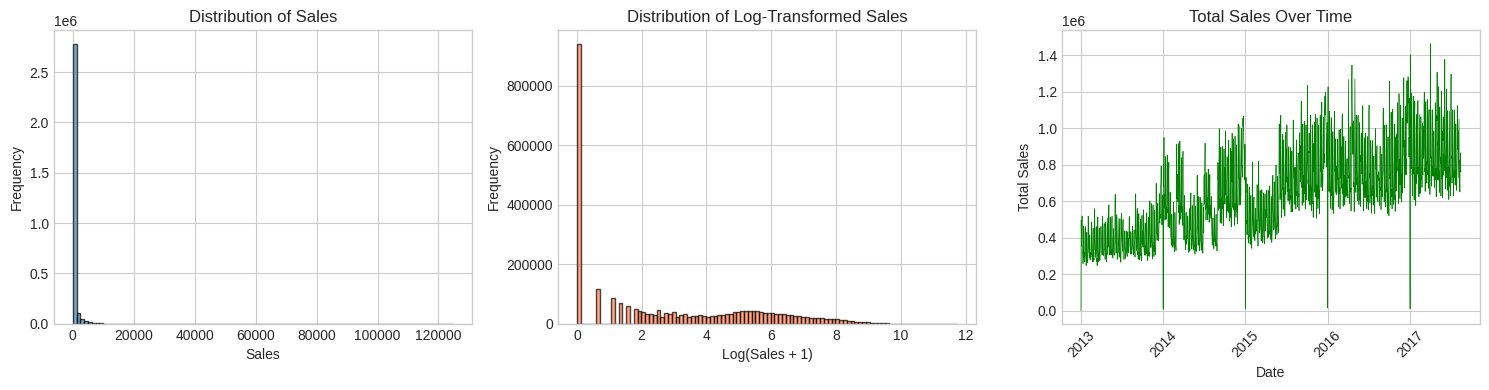


Statistical Summary of Target Class (sales):
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Key Observations regarding sales:
  - Sales range: 0.00 to 124717.00
  - Mean sales: 357.78
  - Median sales: 11.00
  - Zero sales records: 939,130 (31.30%)

Feature data type Analysis:

Train Dataset:
----------------------------------------
  id                   | int64           | Numerical (Continuous)         | Unique: 3000888
  date                 | datetime64[ns]  | Temporal (Date)                | Unique: 1684
  store_nbr            | int64           | Numerical (Continuous)         | Unique: 54
  family               | object          | Categorical (Nominal)          | Unique: 33
  sales                | float64         | Numerical (Continuous)         | Unique: 379610
  onpromotion          | int64           | Numerical (Contin

In [11]:
# 1. DATASET AND DESCRIPTIONS

print(f"Dataset Overview")
total_train_samples = len(train)
total_test_samples = len(test)
num_features = train.shape[1] - 1

print(f"Total number of samples in train dataset: {total_train_samples}")
print(f"Total number of samples in test dataset: {total_test_samples}")
print(f"Total number of samples: {total_train_samples + total_test_samples}")
print(f"Total number of features: {num_features} features + 1 target variable (sales)")

# supplementary datasets overview
print("\nSupplementary Datasets Overview")
print(f"Stores dataset shape: {stores.shape}")
print(f"Oil dataset shape: {oil.shape}")
print(f"Holidays dataset shape: {holidays.shape}")
print(f"Transactions dataset shape: {transactions.shape}")
print(f"Stores metadata: {len(stores)} stores with {stores.shape[1]} features")
print(f"Oil prices: {len(oil)} daily records")
print(f"Holidays: {len(holidays)} holidays")
print(f"Transactions: {len(transactions)} records")


# training data info
print("\nTrain Dataset Structure:")
print(train.info())
print("\nFirst 5 rows of training data:")
display(train.head())

# Data distribution of sales
print("\nData Distribution of target class Sales:")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution of sales
axes[0].hist(train['sales'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sales')


# Log-transformed distribution since we use RMSLE
train['log_sales'] = np.log1p(train['sales'])
axes[1].hist(train['log_sales'], bins=100, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Sales + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Sales')

# Sales over time (aggregated)
daily_sales = train.groupby('date')['sales'].sum().reset_index()
axes[2].plot(daily_sales['date'], daily_sales['sales'], color='green', linewidth=0.5)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Total Sales')
axes[2].set_title('Total Sales Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary of  sales
print("\nStatistical Summary of Target Class (sales):")
print(train['sales'].describe())

print(f"\nKey Observations regarding sales:")
print(f"  - Sales range: {train['sales'].min():.2f} to {train['sales'].max():.2f}")
print(f"  - Mean sales: {train['sales'].mean():.2f}")
print(f"  - Median sales: {train['sales'].median():.2f}")
print(f"  - Zero sales records: {(train['sales'] == 0).sum():,} ({(train['sales'] == 0).mean()*100:.2f}%)")

# Feature analysis
print("\nFeature data type Analysis:")
def analyze_feature_types(df, name):
    print(f"\n{name}:")
    print("-" * 40)
    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()

        if dtype == 'datetime64[ns]':
            ftype = "Temporal (Date)"
        elif dtype in ['int64', 'float64']:
            if nunique < 20:
                ftype = "Categorical (Encoded as Numeric)"
            else:
                ftype = "Numerical (Continuous)"
        elif dtype == 'object':
            ftype = "Categorical (Nominal)"
        elif dtype == 'bool':
            ftype = "Boolean"
        else:
            ftype = "Other"

        print(f"  {col:20} | {str(dtype):15} | {ftype:30} | Unique: {nunique}")

analyze_feature_types(train, "Train Dataset")
analyze_feature_types(stores, "Stores Dataset")
analyze_feature_types(oil, "Oil Dataset")
analyze_feature_types(holidays, "Holidays Dataset")
analyze_feature_types(transactions, "Transactions Dataset")


### **Discussion:**

The implemented code performs a comprehensive initial examination of the **"Store Sales - Time Series Forecasting"** dataset. It utilizes the `Pandas` library for `data structure manipulation` and `Matplotlib` for `visualizing` distributions.

1.   The code first **quantifies** the **scale** of the dataset by calculating the shapes of the `train (3M+ rows)` and `test sets`, as well as the four `supplementary datasets (stores, oil, holidays, transactions)`.
2.   By plotting both the `raw distribution` and the `Log-transformed distribution (np.log1p)`, the code **visually** depicts the extreme skewness of retail sales data. The inclusion of a `time-series plot (daily_sales) aggregates` sales by date, providing an immediate `visual check` for seasonality and trends over the `4-year period`.
3. The `analyze_feature_types` function automates the classification of data type of features . It intelligently distinguishes between `categorical features (like family or city), temporal features (date), and numerical features` based on data types and unique value counts.

### **Analysis:**


1.  **Dataset used :** We utilized the **"Store Sales - Time Series Forecasting(Kaggle Competition)"** dataset contains historical sales data from Corporación Favorita provided by **Favorita**, a major grocery retailer in Ecuador. The dataset is a relational database consisting of a primary training file and several supplementary metadata files(stores, oil, holidays, transactions)..
    *   The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.
    * Link to the dataset: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

2. **Samples in the dataset:**
    * **Train Samples:** 3,000,888 records.
    * **Test Samples:** 28,512 records
    *  **Total Samples:** 3,029,400 rows of time-series data.

3. **Labeled vs. Unlabeled data:**
    * **Labeled data:** The **training data** is labeled, the target class being the  **`sales`** column.
    * **Unlabeled data**: The **test data** is unlabeled has only `store_nbr, family, onpromotion` columns; our objective is to predict the sales column for these rows.

4. **About the Data:**
      * **Type of the data:** This is a **multivariate time-series dataset**. It combines *structured tabular data* (store IDs, product families) with *temporal sequences* (daily records).
      * **Dataset contains:** The data represents retail sales volume for specific product families at specific stores in Ecuador from 2013 to 2017. goal is to predict unit sales for thousands of product families sold at different Favorita stores.


5. **Data Distribution of the target variable `sales`:**
      * The data is highly **right-skewed**. The **mean sales (357.78)** is drastically higher than the **median (11.00)**, indicating a "long tail" of high-volume sales events.
      * A **substantial portion** of the data `(31.30%)` consists of `zero sales`. This suggests that many product families do not sell every day at every store, or the store was closed.
      * **Sales range** from `0 to a maximum of 124,717 units` in a single day for a product family.
